In [2]:
# Importing the required modules

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(1) # Setting the random seed for all data generated randomly

ModuleNotFoundError: No module named 'torch'

In [3]:
# TO DO in this cell

# Data preparation part-1

# Read in the Google stock price data into pandas
# Please make sure you name the dataframe "goog" as it is used in the code later
goog = pd.read_csv('GOOG_08_04_10_19.csv')
print(goog.head())


# Just keep the 'Date' and 'Adj Close' fields / columns
goog = goog.drop(columns=['Open','High','Low','Close','Volume'])
print(goog.head())


# Convert the 'Date' columns to a datetime data type and set it as the index.
goog = goog.set_index('Date')



# Create a new column called 'target' (use the name exactly as written) 
# This column should have all values of the subsequent date
# Example - if todays value in 'Adj Close' is 100 and the next time step has a value of 200 and the one after that has 300,
#           then, 'AdJ Close' columns will have 100,200,300 and 'target' column will have 200,300.
# Use the shift operation appropriately to acheive this.
# Of course, when you do this, there will be one row in the end which will have a 'nan' value and that row should be dropped.
goog['target'] = goog['Adj Close'].shift(-1)
goog = goog.dropna()



print(goog.head(),goog.shape)

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.813286  51.835709  47.800831  49.982655  49.982655  44871300
1  2004-08-20  50.316402  54.336334  50.062355  53.952770  53.952770  22942800
2  2004-08-23  55.168217  56.528118  54.321388  54.495735  54.495735  18342800
3  2004-08-24  55.412300  55.591629  51.591621  52.239193  52.239193  15319700
4  2004-08-25  52.284027  53.798351  51.746044  52.802086  52.802086   9232100
         Date  Adj Close
0  2004-08-19  49.982655
1  2004-08-20  53.952770
2  2004-08-23  54.495735
3  2004-08-24  52.239193
4  2004-08-25  52.802086
            Adj Close     target
Date                            
2004-08-19  49.982655  53.952770
2004-08-20  53.952770  54.495735
2004-08-23  54.495735  52.239193
2004-08-24  52.239193  52.802086
2004-08-25  52.802086  53.753517 (3820, 2)


### If everything goes well in the above cell your data should look like: ###
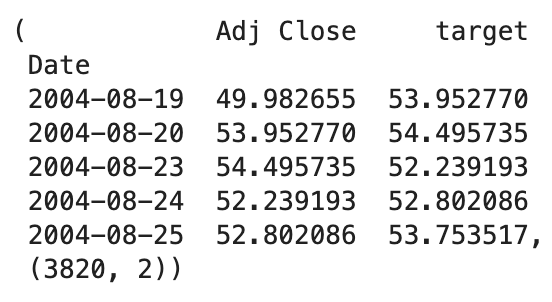


In [3]:
# Let us lsook at the datatypes now
goog.dtypes

Adj Close    float64
target       float64
dtype: object

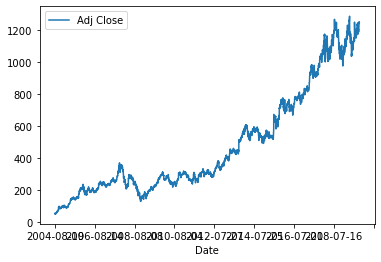

In [4]:
# Plot 

goog.plot(y='Adj Close')
plt.show()

In [5]:
# Create Sequence - What's going on here?

X = np.array(goog['Adj Close']).reshape(-1,1) # Create X
Y = np.array(goog['target']).reshape(-1,1) # Create y

# Normalize data - Why?

sc = MinMaxScaler()
X = sc.fit_transform(X)

# Create Test and Train sets

X_train = X[:len(X)-64]
X_test = X[len(X)-64:]
y_train = Y[:len(X)-64]
y_test = Y[len(X)-64:]

In [1]:
# Convert them to torch tensors - Why?

train_input = torch.from_numpy(X_train).float()
train_target = torch.from_numpy(y_train).float()
test_input = torch.from_numpy(X_test).float()
test_target = torch.from_numpy(y_test).float()

NameError: name 'torch' is not defined

In [7]:
# Check shape

train_input.shape,train_target.shape,test_input.shape

(torch.Size([3756, 1]), torch.Size([3756, 1]), torch.Size([64, 1]))

In [8]:
# Building LSTM model class - Explain the architecture created, draw a sketch? How many inputs, hidden layers, neurons per layer

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 128)
        self.lstm2 = nn.LSTMCell(128, 128)
        self.linear = nn.Linear(128, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(1), 128, dtype=torch.float)
        c_t = torch.zeros(input.size(1), 128, dtype=torch.float)
        h_t2 = torch.zeros(input.size(1), 128, dtype=torch.float)
        c_t2 = torch.zeros(input.size(1), 128, dtype=torch.float)

        for input_t in input.split(1, dim=0):#
            
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=0)
        return outputs

In [9]:
# Cursory check

test_input.type(),train_input.type()

('torch.FloatTensor', 'torch.FloatTensor')

In [10]:
# Instantiate model, metric and optimizer - What's going on here?

model = LSTM()
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.25,max_iter=15) 

In [11]:
# Building the training loop - What's going on here?

def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            future = 9
            pred = model(test_input, future=future)
            y = pred.detach().numpy()
            out = model(train_input)
            loss_print = loss_fn(out, train_target)
            print("Epoch: {}, RMSE Loss: {}".format(i, loss_print**0.5))
    return y,future,loss_print
            

In [12]:
# Training and testing the model - whats going on here?

y,future,loss = training_loop(n_epochs = 10,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              train_input = train_input,
              train_target = train_target,
              test_input = test_input,
              test_target = test_target)



Epoch: 0, RMSE Loss: 316.1636047363281
Epoch: 1, RMSE Loss: 309.0836486816406
Epoch: 2, RMSE Loss: 160.58253479003906
Epoch: 3, RMSE Loss: 478.0132141113281
Epoch: 4, RMSE Loss: 95.0260238647461
Epoch: 5, RMSE Loss: 42.449642181396484
Epoch: 6, RMSE Loss: 32.8414421081543
Epoch: 7, RMSE Loss: 31.01736831665039
Epoch: 8, RMSE Loss: 28.76035499572754
Epoch: 9, RMSE Loss: 27.698875427246094


In [13]:
# Accuracy - What's going on here?

goog_mean = Y.mean()
mse = np.array(loss**0.5)
print(f"Mean Value of the Google Stock over the years:{goog_mean}\nAccuracy Based on mean value %:{100*(goog_mean-np.sqrt(mse))/goog_mean}")

Mean Value of the Google Stock over the years:479.44445982879586
Accuracy Based on mean value %:98.90227704791269


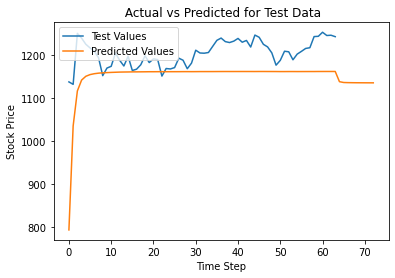

In [14]:
# Plotting actual predited versus actual values for the test data - What am I doing here?

plt.title(' Actual vs Predicted for Test Data')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.plot(y_test,label='Test Values')
plt.plot(y,label='Predicted Values')
plt.legend(loc="upper left")
plt.show()

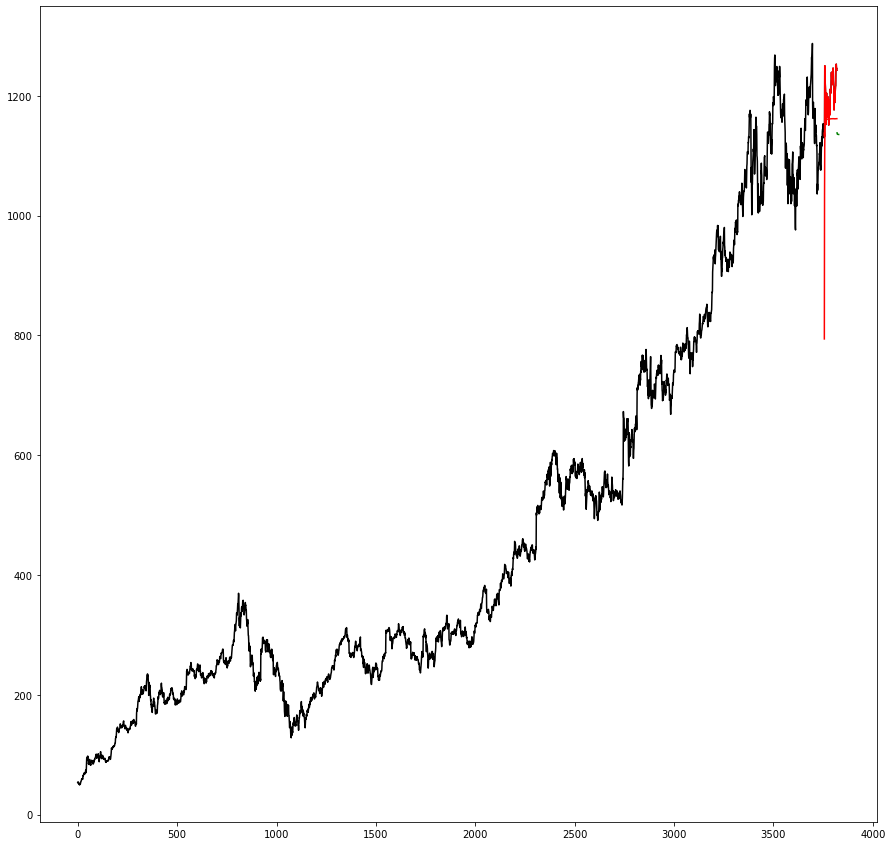

In [15]:
# Plt the complete data including predictions on test data

c = []
for i in range(len(Y)+future):
    c.append(i) 
plt.figure(figsize=(15,15))
plt.plot(c[:len(Y)],Y,c='black')
plt.plot(c[len(train_input):len(train_input)+len(test_input)],y_test,c='r')
plt.plot(c[len(train_input):len(train_input)+len(test_input)],y[:len(test_input)],c='r')
plt.plot(c[len(Y):],y[len(Y)-(len(Y)+future):],c='Green')

plt.show()